# Message Passing Interface in Python
MPI or Message Passing Interface is a standard for Distributed Memory Programming and to communication between multiple processes running on CPUs. These processes can be on the same or multiple compute nodes. The compute nodes are usually connected via high speed interconnect for low latency and high bandwidth. The MPI libraries based on this standard provide C, C++ and Fortran bindings.

<b>The main strength of MPI library is it's ability to scale upto thousands of CPUs.</b>




<b>mpi4py</b> is a Python package that provides bindings of MPI standard in Python programming language.

The bindings or communication functions in MPI can be pooled into 3 major communication patterns:
1. Point to Point communication
2. Collective communication
3. One-sided communication

1 and 2 are most commonly used communication patterns in the MPI applications running on Shaheen. 

In [27]:
# The is only relevant to running mpi4py in a Jupyter notebook.
import ipyparallel
cluster=ipyparallel.Client(profile='mpi_tutorial')
print("IDs:",cluster.ids)

IDs: [0, 1, 2, 3, 4, 5, 6, 7]


In [28]:
%%px
from mpi4py import MPI

# Hello World
Here each MPI process (rank) queries it Identity (rank) and the total number of MPI ranks in MPI_COMM_WORLD

In [29]:
%%px 
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print ("I'm rank %d of %d on %s" %(rank,size,MPI.Get_processor_name()))

[stdout:0] I'm rank 3 of 8 on cn509-11-l
[stdout:1] I'm rank 0 of 8 on cn509-11-l
[stdout:2] I'm rank 1 of 8 on cn509-11-l
[stdout:3] I'm rank 2 of 8 on cn509-11-l
[stdout:4] I'm rank 6 of 8 on cn509-11-r
[stdout:5] I'm rank 4 of 8 on cn509-11-r
[stdout:6] I'm rank 5 of 8 on cn509-11-r
[stdout:7] I'm rank 7 of 8 on cn509-11-r


# Point to Point Communication
The basic idea of communication in MPI is that:
    - one MPI process send a message 
    - the other MPI process receieves that message
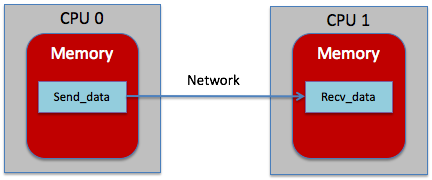

A message has two fundamental components:
1. Envelope (who is the sender/receipent)
2. Message body (data)

All the MPI processes exist in a context called a communicator.

When a MPI program launches, a default communicator is created called MPI_COMM_WORLD. 

### Example
This is a example where two MPI tasks are involved. One MPI task is going to send a Numpy array and the other is going to recieve it.

#### Send Receive Numpy buffer

In [4]:
%%px
import numpy as np

rank = comm.Get_rank()

# passing MPI datatypes explicitly
if rank == 0:
    data = np.arange(5, dtype='i')
    comm.Send([data, MPI.INT], dest=1, tag=77)
elif rank == 1:
    data = np.empty(5, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)
    print("[rank:%d]" %rank, data)

[stdout:2] [rank:1] [0 1 2 3 4]


#### Send Receive Python Object
e.g. Python list(), dict()

In [5]:
%%px
if rank == 0:
    data = [i for i in range(10)]
    comm.send(data, dest=1, tag=13)
elif rank == 1:
    data=comm.recv(source=0, tag=13)
    print("[rank:%d]" %rank,data)
    print("Type of recieved data is ",type(data))

[stdout:2] 
[rank:1] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Type of recieved data is  <class 'list'>


One can send and recieve generic Python objects such as lists and dictioaries. Function bindings start with small case for communicating Python objects.

<b>
    
    comm.send()
    comm.recv()
</b>
Automatic type matching workings well when Python Objects are being communicated.

In [6]:
%%px
rank = comm.Get_rank()

if rank == 0:
    data = {'a': 7, 'b': 3.14}
    comm.send(data, dest=1, tag=11)
elif rank == 1:
    data = comm.recv(source=0, tag=11)
    print("[rank:%d]" %rank,data)

[stdout:2] [rank:1] {'a': 7, 'b': 3.14}


# Collectives
Another powerful communication pattern the MPI standard offers is collective communication opreations.
mpi4py provides binds for corresponding MPI collectives.

Following is a list of common collective communication opreations one should know when developing an MPI program.

### Broadcast
<pre>
comm.bcast(data, root)
comm.Bcast(data,root)
</pre>
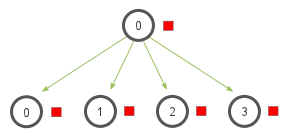

### Gather
<pre>
comm.gather(data,root)
comm.Gather(sendbuf,recvbuf,root)
</pre>
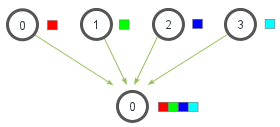

### Scatter
<pre>
comm.scatter(data,root)
comm.Scatter(sendbuf,recvbuf,root)
</pre>
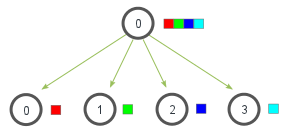

### Reduction
<pre>
comm.reduce(sendobj,op=MPI.OPERATION,root)
comm.Reduce(sendbuf,reducebuf,op=MPI.OPERATION,root)
</pre>

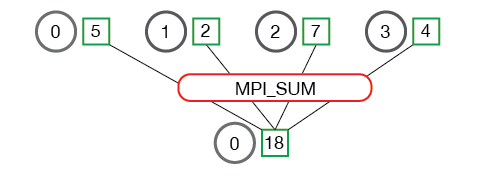

## Example
For demonstration, let us approximate area under a curve using Simpon method of integration.

- Assume we have smooth continous function over a finite interval [0,1]

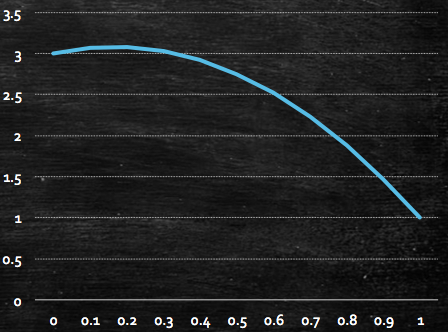
- We want to evalute its integral over the interval <font size ="3"> $\int_0^1 f(x) dx$ </font>


- <font size="5"> Numerically </font> it can be approximated as  <font size ="5"> $\int_0^1 f(x) dx \approx \sum_{i=1}^N = a_i$ </font>
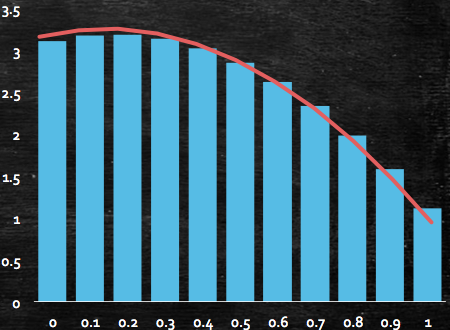

- Area under the curve is approximated as of the areas of all the rectangles.

## Parallelising using MPI
- More rectanlges lead to better approximation. But this comes at the cost of more computation.
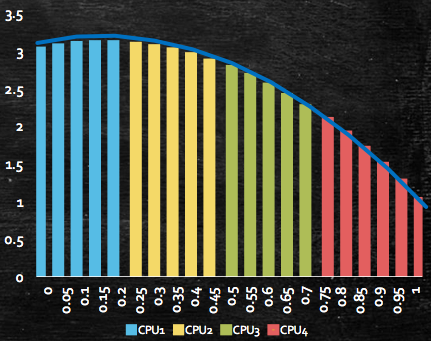
- We can distribute the computation to MPI ranks/processes running one core to compute partial sums.
- We can then reduce the sum of all the partial sums on to root rank (let's say 0)

The compute function which needs to be computed for each x is defined on every MPI rank

In [42]:
%%px 
def integrate( x, dx ):
    area = np.zeros(1)
    area[0] = 0.0
    for i in x:
        area += dx * (3.0 + i - 3.0*i*i)
        if rank ==0:
            print(area[0])
    return area

### Domain decomposition
- Each MPI rank figures out it part of the 1D domain by marking the start and end based on the total rectangles and the total MPI ranks 
- Last MPI rank gets the remaining rectangles if  <font size = "4">$\frac{Total\_rectanlges}{size}$</font>  is not exactly divisible
        

In [52]:
%%px
size = comm.Get_size()
rank = comm.Get_rank()

# Since the interval was from 0 to 1
x1=0.0
x2=1.0
# Let's create a 1D domain. dx is the space between each point.  
dx=1e-2

total_rectangles = int( (x2-x1)/dx )
my_num_rectangles = int( total_rectangles / size )
start = my_num_rectangles * rank + 1
end = my_num_rectangles * (rank + 1) 

if rank == size-1 :
    if divmod(total_rectangles,size)[1] !=0 :
        end = end + divmod(total_rectangles,size)[1]

points = np.arange(start,end)
points = points * dx

Since every MPI rank now has its domain figured out, they can all compute.

In [53]:
%%px
local_area = np.zeros(1)
local_area[0] = integrate(points,dx)

In [54]:
%%px
computed_area=np.zeros(1)
comm.Reduce(local_area,computed_area,op=MPI.SUM,root=0)
if rank == 0 :
    print("Total area = ",computed_area)

[stdout:1] Total area =  [2.45422252]
